In [1]:
pip install git+https://github.com/TransformerLensOrg/TransformerLens

  Cloning https://github.com/TransformerLensOrg/TransformerLens to /tmp/pip-req-build-ph2op_2f
  Running command git clone --filter=blob:none --quiet https://github.com/TransformerLensOrg/TransformerLens /tmp/pip-req-build-ph2op_2f
  Resolved https://github.com/TransformerLensOrg/TransformerLens to commit 50ee38b9a20695e90b8ce6a4aa20fd509c8175d9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 133.8 MB/s eta 0:00:00
  Created wheel for transformer-lens: filename=transformer_lens-0.0.0-py3-none-any.whl size=192059 sha256=97d2b8e5a44aab1fafa19179ad4625b65c69b089e6e1ea281f6

In [1]:
import torch
import numpy
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
from transformer_lens import HookedTransformerConfig, HookedTransformer

# Make the HookedTransformer Config
cfg = HookedTransformerConfig(
    n_layers = 1,
    d_model = 128,
    n_heads = 4,
    d_head = 32,
    n_ctx = 3,
    d_vocab = 114,
    act_fn = 'relu',
    seed = 999,
    normalization_type = None
)

In [3]:
prime_P = 113
dataset = []
temp_arr = []
labels = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(prime_P):
  for j in range(prime_P):
    temp_arr = []
    label = (i+j)%prime_P

    temp_arr.append(i)
    temp_arr.append(j)
    temp_arr.append(113)
    temp_arr = torch.tensor(temp_arr, dtype = torch.long)
    label = torch.tensor(label, dtype=torch.long)

    dataset.append(temp_arr)
    labels.append(label)

main_dataset = torch.stack(dataset, dim=0).to(device)
labels = torch.stack(labels, dim=0).to(device)

print(f"Using Device: {device}")
print(main_dataset.shape)
print(labels.shape)

Using Device: cuda
torch.Size([12769, 3])
torch.Size([12769])


In [4]:
data = TensorDataset(main_dataset, labels)

train_size = int(0.30 * len(data))
val_size = len(data) - train_size

train_ds, val_ds = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=train_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=val_size)

print(f"Training Set: {len(train_ds)}")
print(f"Validation Set: {len(val_ds)}")

model = HookedTransformer(cfg)
model.to(device)

Training Set: 3830
Validation Set: 8939
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [7]:
num_epochs = 20000
loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1.0)

val_inputs, val_labels = next(iter(val_loader))
val_inputs.to(device)
val_inputs.to(device)

for epoch in range(num_epochs):

  logits, labels = next(iter(train_loader))
  logits.to(device)
  labels.to(device)

  outputs = model(logits)
  final_output_logits = outputs[:, -1, :]
  loss = loss_fn(final_output_logits, labels)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  val_outputs = model(val_inputs)
  val_final_output_logits = val_outputs[:, -1, :]
  val_loss = loss_fn(val_final_output_logits, val_labels)

  train_acc = torch.sum(torch.argmax(final_output_logits, dim=-1) == labels) / final_output_logits.size(0)
  val_acc = torch.sum(torch.argmax(val_final_output_logits, dim=-1) == val_labels) / val_final_output_logits.size(0)

  if (epoch+1) % 500 == 0:
    print(f"Epoch: {epoch}, Train Loss: {loss.item()}, Train Acc: {train_acc.item()}, Val Acc: {val_acc.item()}")

    if val_acc.item() > 0.975:
      break

Epoch: 499, Train Loss: 0.016067981719970703, Train Acc: 1.0, Val Acc: 0.011634411290287971
Epoch: 999, Train Loss: 0.008425424806773663, Train Acc: 1.0, Val Acc: 0.012753104791045189
Epoch: 1499, Train Loss: 0.005271475296467543, Train Acc: 1.0, Val Acc: 0.014990491792559624
Epoch: 1999, Train Loss: 0.0035275653935968876, Train Acc: 1.0, Val Acc: 0.016780400648713112
Epoch: 2499, Train Loss: 0.002459954237565398, Train Acc: 1.0, Val Acc: 0.01924152672290802
Epoch: 2999, Train Loss: 0.0017567952163517475, Train Acc: 1.0, Val Acc: 0.022038260474801064
Epoch: 3499, Train Loss: 0.0012750866590067744, Train Acc: 1.0, Val Acc: 0.02505873143672943
Epoch: 3999, Train Loss: 0.0009343863930553198, Train Acc: 1.0, Val Acc: 0.030652198940515518
Epoch: 4499, Train Loss: 0.0006907582865096629, Train Acc: 1.0, Val Acc: 0.040832310914993286
Epoch: 4999, Train Loss: 0.0005101371789351106, Train Acc: 1.0, Val Acc: 0.05571093037724495
Epoch: 5499, Train Loss: 0.000376334588509053, Train Acc: 1.0, Val Ac

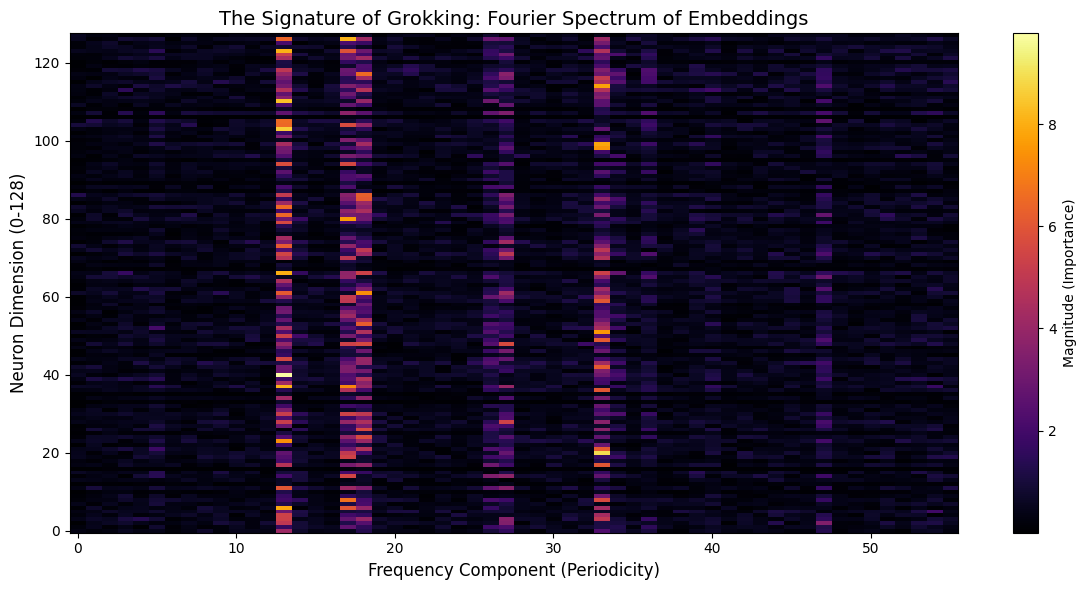

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
W_E = model.W_E.detach().cpu()
W_E_numbers = W_E[:-1, :]

fft_result = torch.fft.fft(W_E_numbers, dim=0)
fft_magnitude = torch.abs(fft_result)

half_n = fft_magnitude.shape[0] // 2
fft_viz = fft_magnitude[:half_n, :]

plt.figure(figsize=(12, 6))
plt.imshow(fft_viz.T, aspect='auto', cmap='inferno', origin='lower')

plt.title("The Signature of Grokking: Fourier Spectrum of Embeddings", fontsize=14)
plt.xlabel("Frequency Component (Periodicity)", fontsize=12)
plt.ylabel("Neuron Dimension (0-128)", fontsize=12)
plt.colorbar(label="Magnitude (Importance)")
plt.tight_layout()
plt.show()

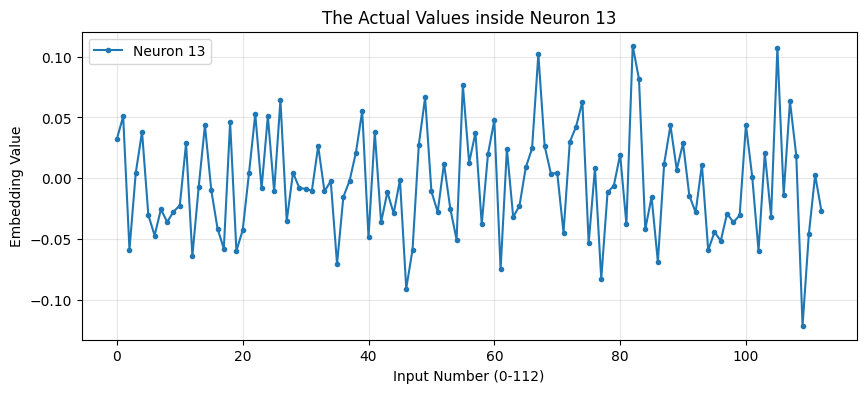

In [18]:
neuron_scores = torch.sum(fft_viz, dim=1) # Sum across frequencies
best_neuron_idx = torch.argmax(neuron_scores).item()

neuron_values = W_E_numbers[:, best_neuron_idx].numpy()

plt.figure(figsize=(10, 4))
plt.plot(neuron_values, marker='o', markersize=3, label=f"Neuron {best_neuron_idx}")
plt.title(f"The Actual Values inside Neuron {best_neuron_idx}")
plt.xlabel("Input Number (0-112)")
plt.ylabel("Embedding Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

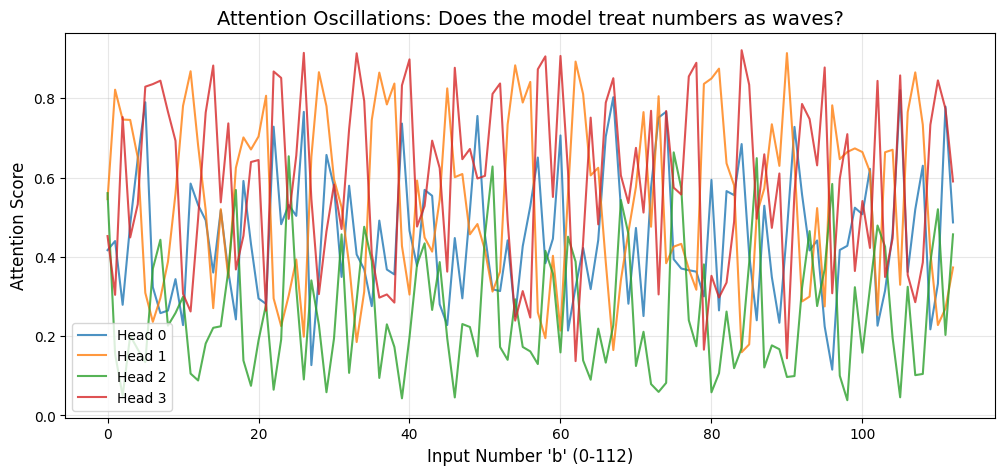

In [12]:
queries = torch.zeros((113, 3), dtype=torch.long).to(device)
queries[:, 0] = 0
queries[:, 1] = torch.arange(113).to(device)
queries[:, 2] = 113

with torch.no_grad():
    logits, cache = model.run_with_cache(queries)

attn = cache['pattern', 0, 'attn']
attention_to_b = attn[:, :, 2, 1].cpu()

plt.figure(figsize=(12, 5))
for head_idx in range(4):
    plt.plot(attention_to_b[:, head_idx], label=f"Head {head_idx}", alpha=0.8)

plt.title("Attention Oscillations: Does the model treat numbers as waves?", fontsize=14)
plt.xlabel("Input Number 'b' (0-112)", fontsize=12)
plt.ylabel("Attention Score", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()